# Credit Risk Model (Home Loan) — Defining & Creating the target variable (Step 2)

### 2A. Calculation and Visualization of %30+,%60+ and %90+ accross MOB

In [9]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path(r"/Users/abhijit/Desktop/Courses/Application Score Card - Home Loan/Data/1. Data Generation")

# read all parts
files = sorted(DATA_DIR.glob("loan_performance_part_*.csv"))
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)


df["flag_30"] = df["Current_DPD"].apply(lambda x: 1 if x>=30 else 0)
df["flag_60"] = df["Current_DPD"].apply(lambda x: 1 if x>=60 else 0)
df["flag_90"] = df["Current_DPD"].apply(lambda x: 1 if x>=90 else 0)

# MOB summary
mob_summary = (df.groupby("MOB")
                 .agg(row_count=("Loan_ID","size"),
                      sum_30=("flag_30","sum"),
                      sum_60=("flag_60","sum"),
                      sum_90=("flag_90","sum"))
                 .reset_index()
                 .sort_values("MOB"))

mob_summary["%90p"]=round(mob_summary["sum_90"]/mob_summary["row_count"],2)
mob_summary["%60p"]=round(mob_summary["sum_60"]/mob_summary["row_count"],2)
mob_summary["%30p"]=round(mob_summary["sum_30"]/mob_summary["row_count"],2)

#mob_summary.to_csv(DATA_DIR / "mob_summary_30_60_90.csv", index=False)
mob_summary.head()


,MOB,row_count,sum_30,sum_60,sum_90,%90p,%60p,%30p
0,1,65349,0,0,0,0.00,0.00,0.00
1,2,65349,4882,0,0,0.00,0.00,0.07
2,3,65349,7937,3397,0,0.00,0.05,0.12
3,4,65349,10244,4244,1103,0.02,0.06,0.16
4,5,65349,11762,6151,1410,0.02,0.09,0.18


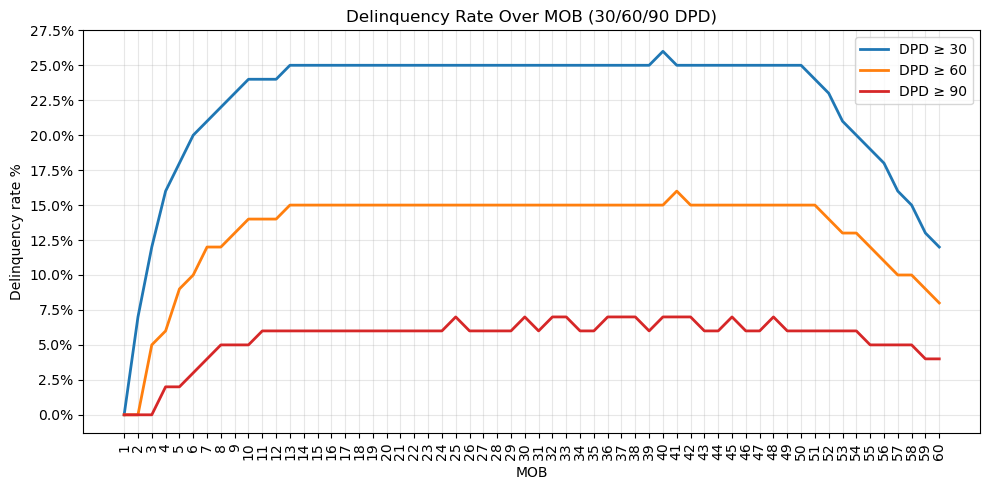

In [10]:
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(mob_summary["MOB"], mob_summary["%30p"], label="DPD ≥ 30", color="tab:blue", linewidth=2)
plt.plot(mob_summary["MOB"], mob_summary["%60p"], label="DPD ≥ 60", color="tab:orange", linewidth=2)
plt.plot(mob_summary["MOB"], mob_summary["%90p"], label="DPD ≥ 90", color="tab:red", linewidth=2)

plt.xlabel("MOB")
plt.ylabel("Delinquency rate %")
plt.title("Delinquency Rate Over MOB (30/60/90 DPD)")
plt.legend()
plt.grid(True, alpha=0.3)

ax = plt.gca()
ymin, ymax = ax.get_ylim()
ax.set_yticks(np.arange(0, ymax + 0.025, 0.025))   # ✅ more y labels
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))  # ✅ adds %

plt.xticks(mob_summary["MOB"], rotation=90)

plt.tight_layout()
plt.show()


In [11]:
p_90_12mob=mob_summary.loc[mob_summary["MOB"] == 12, "%90p"].values[0]
print(f"%90+ at 12 MOB: {p_90_12mob:.2%}")

%90+ at 12 MOB: 6.00%


### 2B. Finalization of Target Variable

- There is a sharp increase in %30+, %60+, %90+ delinquency till 11 MOB.
- %90+ remains steady from 12 MOB onwards
- From 50 MOB it declines graduely
- Since %90+ stabilizes by 12 MOB w, %90+ at 12 MOB is selected as the target variable

### 2C. Mapping the target variable to the application data

In [12]:
application_df=pd.read_csv("/Users/abhijit/Desktop/Courses/Application Score Card - Home Loan/Data/1. Data Generation/home_loan_applications.csv")

In [13]:
approved_application_df=application_df[application_df['Approval_Status']=='Approved']

In [14]:
approved_application_df.shape

(65349, 20)

In [15]:
approved_application_df=approved_application_df.drop(columns=['Rejection_Reason'])

In [16]:
approved_application_df.shape

(65349, 19)

In [17]:
df_12mob=df[df["MOB"]==12]

In [18]:
df_12mob.head()

,Loan_ID,MOB,Amount_Paid,Balance,Current_DPD,Risk_Score,flag_30,flag_60,flag_90
11,1ebc97bf-aa91-4227-a5d2-cb9a5ae24214,12,3977.40,146212.67,0,0.1004,0,0,0
71,ce0ea6f5-296a-488a-bb69-ff8d80273dbb,12,1872.77,252716.12,90,0.2034,1,1,1
131,1d1104c0-3f38-427d-bad7-c33748366c24,12,6871.85,242901.07,0,0.2192,0,0,0
191,de6da9da-3cc0-4d6a-ba39-3e041c67afe4,12,550.40,211631.99,120,0.2104,1,1,1
251,035be979-7ed7-4f31-b968-c729c66d4c73,12,3665.45,239480.54,30,0.1463,1,0,0


In [19]:
df_12mob.shape

(65349, 9)

In [20]:
approved_application_df=approved_application_df.merge(df_12mob[["Loan_ID","flag_90"]], on="Loan_ID", how="left")

In [21]:
pd.set_option("display.max_columns", None)

In [22]:
approved_application_df.head()

,Customer_ID,Loan_ID,Loan_Amount,Property_Value,Income,Credit_Score,Debt_to_Income_Ratio,LTV_Ratio,Employment_Type,Cash_Reserves_Months,Cash_Reserves_Amount,Marital_Status,Property_Occupancy,Application_Score,Gender,Age,Current_State,Current_Property_Type,Approval_Status,flag_90
0,5d087fc1-65ad-4f6e-a97b-a78534af3604,1ebc97bf-aa91-4227-a5d2-cb9a5ae24214,173763.19,340712.14,138702.56,849,0.21,0.51,Self-employed,8.3,95935.94,Single,Rented,132,Male,26,SC,Own,Approved,0
1,33ed473d-43e2-422f-8c65-1123d1a1594f,ce0ea6f5-296a-488a-bb69-ff8d80273dbb,302560.28,392935.43,69552.35,830,0.59,0.77,Retired,11.9,68972.75,Single,Owner-occupied,814,Female,42,DE,Rented,Approved,1
2,15004ca4-f668-46e1-b57f-1934ceb495b3,1d1104c0-3f38-427d-bad7-c33748366c24,298418.28,445400.42,195429.68,765,0.23,0.67,Unemployed,9.7,157972.32,Single,Owner-occupied,891,Female,26,WA,Own,Approved,0
3,d5f6febf-fef1-4c50-a2dd-5223362732bc,de6da9da-3cc0-4d6a-ba39-3e041c67afe4,254034.64,379156.18,177302.22,760,0.14,0.67,Contractor,11.4,168437.11,Married,Owner-occupied,723,Male,55,KY,Own,Approved,1
4,b0375588-c012-4826-8ac9-1f6b5621f675,035be979-7ed7-4f31-b968-c729c66d4c73,312589.82,453028.72,156992.35,849,0.16,0.69,Contractor,10.4,136060.04,Single,Owner-occupied,256,Male,64,DC,Rented,Approved,0


In [23]:
df_12mob.shape

(65349, 9)

In [24]:
approved_application_df['flag_90'].value_counts(dropna=False)

flag_90
0    61517
1     3832
Name: count, dtype: int64

In [25]:
approved_application_df=approved_application_df.rename(columns={'flag_90':'flag_%90p_12MOB'})

In [26]:
approved_application_df.head()

,Customer_ID,Loan_ID,Loan_Amount,Property_Value,Income,Credit_Score,Debt_to_Income_Ratio,LTV_Ratio,Employment_Type,Cash_Reserves_Months,Cash_Reserves_Amount,Marital_Status,Property_Occupancy,Application_Score,Gender,Age,Current_State,Current_Property_Type,Approval_Status,flag_%90p_12MOB
0,5d087fc1-65ad-4f6e-a97b-a78534af3604,1ebc97bf-aa91-4227-a5d2-cb9a5ae24214,173763.19,340712.14,138702.56,849,0.21,0.51,Self-employed,8.3,95935.94,Single,Rented,132,Male,26,SC,Own,Approved,0
1,33ed473d-43e2-422f-8c65-1123d1a1594f,ce0ea6f5-296a-488a-bb69-ff8d80273dbb,302560.28,392935.43,69552.35,830,0.59,0.77,Retired,11.9,68972.75,Single,Owner-occupied,814,Female,42,DE,Rented,Approved,1
2,15004ca4-f668-46e1-b57f-1934ceb495b3,1d1104c0-3f38-427d-bad7-c33748366c24,298418.28,445400.42,195429.68,765,0.23,0.67,Unemployed,9.7,157972.32,Single,Owner-occupied,891,Female,26,WA,Own,Approved,0
3,d5f6febf-fef1-4c50-a2dd-5223362732bc,de6da9da-3cc0-4d6a-ba39-3e041c67afe4,254034.64,379156.18,177302.22,760,0.14,0.67,Contractor,11.4,168437.11,Married,Owner-occupied,723,Male,55,KY,Own,Approved,1
4,b0375588-c012-4826-8ac9-1f6b5621f675,035be979-7ed7-4f31-b968-c729c66d4c73,312589.82,453028.72,156992.35,849,0.16,0.69,Contractor,10.4,136060.04,Single,Owner-occupied,256,Male,64,DC,Rented,Approved,0


In [27]:
approved_application_df.to_csv("/Users/abhijit/Desktop/Courses/Application Score Card - Home Loan/Data/2. Taget Variable/approved_application.csv", index=False)